<a href="https://colab.research.google.com/github/vxcdnn/CVin3D9/blob/main/lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ЛР №5**: Классификация 3D-объектов на основе облака точек с использованием архитектуры PointNet и датасета ModelNet (ShapeNet)

**Исходные данные:**

**Датасет:** ModelNet10

**Формат:** .off (объекты в виде 3D-мешей)
Каждый объект принадлежит одной из 10 категорий.

**Количество точек:** для упрощения используем 1024 точки на объект (равномерное
сэмплирование с поверхности).

## **Ход работы**

## **Шаг 1. Загрузка и подготовка данных**

Для обучения на GPU нужно:


Среда выполнения -> Сменить среду выполнения-> Аппаратный ускоритель

In [62]:
!pip install open3d numpy h5py tqdm matplotlib

In [63]:
import platform
print(platform.python_version())

3.12.12


In [64]:
import os
import shutil
import glob
import zipfile
import requests
from tqdm import tqdm
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sns
import h5py
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import open3d as o3d
import json

def download_modelnet10(url="http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
                       dest_folder="ModelNet10"):
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder, exist_ok=True)
        print("Скачивание ModelNet10...")
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        zip_path = os.path.join(dest_folder, "ModelNet10.zip")

        with open(zip_path, "wb") as f, tqdm(
            desc="Загрузка",
            total=total_size,
            unit="B",
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
            for chunk in response.iter_content(chunk_size=1024):
                f.write(chunk)
                bar.update(len(chunk))

        print("Распаковка...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(dest_folder)
        os.remove(zip_path)
        print("Готово!")
    else:
        print("ModelNet10 уже загружен.")

In [65]:
download_modelnet10()

ModelNet10 уже загружен.


In [66]:
if os.path.exists("ModelNet10/ModelNet10"):
    print("Обнаружена вложенная папка ModelNet10/ModelNet10")
    inner_dir = "ModelNet10/ModelNet10"
    outer_dir = "ModelNet10_temp"
    shutil.move(inner_dir, outer_dir)
    shutil.rmtree("ModelNet10")  # удаляем старую папку
    os.rename(outer_dir, "ModelNet10")  # переименовываем
    print("Структура исправлена!")
else:
    print("Вложенная папка не найдена.")

Вложенная папка не найдена.


In [67]:
print("Содержимое корневой папки:")
print(os.listdir("ModelNet10"))

off_files = glob.glob("ModelNet10/*/*/*.off")
print(f"\nНайдено .off файлов: {len(off_files)}")

if off_files:
    print("Пример:", off_files[0])
else:
    print(".off файлы не найдены")

Содержимое корневой папки:
['chair', 'monitor', '.DS_Store', 'dresser', 'README.txt', 'bed', 'sofa', 'bathtub', 'table', 'night_stand', 'desk', 'toilet']

Найдено .off файлов: 4899
Пример: ModelNet10/chair/test/chair_0958.off


In [68]:
def read_off(file):
    line = file.readline().strip()
    while line.startswith('#') or line == '':
        line = file.readline().strip()

    if 'OFF' not in line:
        raise ValueError("Invalid OFF file: 'OFF' header not found")

    if len(line) > 3:
        numbers = line[3:].strip().split()
    else:
        numbers = file.readline().strip().split()
        while numbers == [] or numbers[0].startswith('#'):
            numbers = file.readline().strip().split()

    if len(numbers) == 3:
        n_verts, n_faces, _ = map(int, numbers)
    elif len(numbers) == 2:
        n_verts, n_faces = map(int, numbers)
    else:
        raise ValueError(f"Unexpected number of values in header: {numbers}")

    verts = []
    for _ in range(n_verts):
        line = file.readline().strip()
        while line == '' or line.startswith('#'):
            line = file.readline().strip()
        verts.append([float(x) for x in line.split()[:3]])  # только x, y, z

    faces = []
    for _ in range(n_faces):
        line = file.readline().strip()
        while line == '' or line.startswith('#'):
            line = file.readline().strip()
        face_data = [int(x) for x in line.split()]
        if len(face_data) < 4:
            continue
        faces.append(face_data[1:])

    return verts, faces


def sample_points_from_off(file_path, num_points=1024):
    try:
        with open(file_path, 'r') as f:
            verts, faces = read_off(f)
    except Exception as e:
        print(f"Ошибка чтения {file_path}: {e}")
        return None

    verts = np.array(verts, dtype=np.float32)
    if len(verts) == 0:
        return None

    if len(faces) == 0:
        if len(verts) >= num_points:
            idx = np.random.choice(len(verts), num_points, replace=False)
        else:
            idx = np.random.choice(len(verts), num_points, replace=True)
        return verts[idx]

    triangles = []
    for face in faces:
        if len(face) < 3:
            continue
        elif len(face) == 3:
            triangles.append(face)
        else:
            for i in range(1, len(face) - 1):
                triangles.append([face[0], face[i], face[i+1]])

    triangles = np.array(triangles)
    if len(triangles) == 0:
        if len(verts) >= num_points:
            idx = np.random.choice(len(verts), num_points, replace=False)
        else:
            idx = np.random.choice(len(verts), num_points, replace=True)
        return verts[idx]

    valid_mask = np.all(triangles < len(verts), axis=1) & np.all(triangles >= 0, axis=1)
    triangles = triangles[valid_mask]
    if len(triangles) == 0:
        if len(verts) >= num_points:
            idx = np.random.choice(len(verts), num_points, replace=False)
        else:
            idx = np.random.choice(len(verts), num_points, replace=True)
        return verts[idx]

    v0 = verts[triangles[:, 0]]
    v1 = verts[triangles[:, 1]]
    v2 = verts[triangles[:, 2]]
    cross = np.cross(v1 - v0, v2 - v0)
    areas = np.linalg.norm(cross, axis=1)
    areas = np.clip(areas, 1e-10, None)
    prob = areas / areas.sum()

    try:
        sampled_tri = np.random.choice(len(triangles), size=num_points, p=prob)
    except ValueError:
        sampled_tri = np.random.choice(len(triangles), size=num_points, p=None)

    r1 = np.sqrt(np.random.rand(num_points))
    r2 = np.random.rand(num_points)
    u = 1 - r1
    v = r1 * (1 - r2)
    w = r1 * r2

    tri_verts = verts[triangles[sampled_tri]]
    points = u[:, None] * tri_verts[:, 0] + v[:, None] * tri_verts[:, 1] + w[:, None] * tri_verts[:, 2]
    return points

In [69]:
def normalize_points(points):
    """Нормализуем координаты в [-1, 1]."""
    centroid = np.mean(points, axis=0)
    points = points - centroid
    max_abs = np.max(np.abs(points))
    if max_abs > 0:
        points = points / max_abs
    return points

In [70]:
def process_modelnet10_to_h5(root_dir="ModelNet10", output_path="modelnet10_1024.h5", num_points=1024):
    categories = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
    class_to_label = {cat: idx for idx, cat in enumerate(categories)}

    train_points, train_labels = [], []
    test_points, test_labels = [], []

    for cat in categories:
        label = class_to_label[cat]
        for split in ["train", "test"]:
            pattern = os.path.join(root_dir, cat, split, "*.off")
            files = glob.glob(pattern)
            for f in files:
                points = sample_points_from_off(f, num_points=num_points)
                if points is None or points.shape != (num_points, 3):
                    continue
                points = normalize_points(points)
                if split == "train":
                    train_points.append(points)
                    train_labels.append(label)
                else:
                    test_points.append(points)
                    test_labels.append(label)

    with h5py.File(output_path, "w") as f:
        f.create_dataset("train_points", data=np.array(train_points, dtype=np.float32))
        f.create_dataset("train_labels", data=np.array(train_labels, dtype=np.int64))
        f.create_dataset("test_points", data=np.array(test_points, dtype=np.float32))
        f.create_dataset("test_labels", data=np.array(test_labels, dtype=np.int64))
        f.create_dataset("class_names", data=[c.encode("utf-8") for c in categories])

    print(f"Сохранено {len(train_points)} тренировочных и {len(test_points)} тестовых образцов.")

In [71]:
process_modelnet10_to_h5()

Сохранено 3991 тренировочных и 908 тестовых образцов.


## Шаг 2. Реализация архитектуры PointNet

In [72]:
class TNet(nn.Module):
    def __init__(self, k=3):
        super(TNet, self).__init__()
        self.k = k
        self.mlp1 = nn.Sequential(
            nn.Conv1d(k, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 1024, 1),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, k * k)
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = self.mlp1(x)
        x = F.adaptive_max_pool1d(x, 1).squeeze(2)
        x = self.fc(x)

        identity = torch.eye(self.k, device=x.device).view(1, self.k * self.k).expand(batch_size, -1)
        x = x + identity
        x = x.view(-1, self.k, self.k)
        return x

In [73]:
class PointNetClassifier(nn.Module):
    def __init__(self, num_classes=10, feature_transform=True):
        super(PointNetClassifier, self).__init__()
        self.feature_transform = feature_transform

        self.input_transform = TNet(k=3)

        self.mlp1 = nn.Sequential(
            nn.Conv1d(3, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
        )

        if self.feature_transform:
            self.feature_transform_net = TNet(k=64)
            self.mlp2 = nn.Sequential(
                nn.Conv1d(64, 64, 1),
                nn.BatchNorm1d(64),
                nn.ReLU(),
                nn.Conv1d(64, 128, 1),
                nn.BatchNorm1d(128),
                nn.ReLU(),
                nn.Conv1d(128, 1024, 1),
                nn.BatchNorm1d(1024),
                nn.ReLU(),
            )
        else:
            self.mlp2 = nn.Sequential(
                nn.Conv1d(64, 128, 1),
                nn.BatchNorm1d(128),
                nn.ReLU(),
                nn.Conv1d(128, 1024, 1),
                nn.BatchNorm1d(1024),
                nn.ReLU(),
            )

        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):

        trans_input = self.input_transform(x)
        x = torch.bmm(trans_input, x)

        x = self.mlp1(x)

        trans_feat = None
        if self.feature_transform:
            trans_feat = self.feature_transform_net(x)
            x = torch.bmm(trans_feat, x)

        x = self.mlp2(x)

        x = F.adaptive_max_pool1d(x, 1).squeeze(2)

        x = self.classifier(x)

        return x, trans_input, trans_feat

In [74]:
def feature_transform_regularizer(trans):
    d = trans.size()[1]
    I = torch.eye(d, device=trans.device).unsqueeze(0)  # (1, d, d)
    loss = torch.mean(torch.norm(torch.bmm(trans, trans.transpose(2, 1)) - I, dim=(1, 2)))
    return loss

## Шаг 3. Обучение модели

In [75]:
class ModelNet10Dataset(Dataset):
    def __init__(self, h5_path, split='train'):
        with h5py.File(h5_path, 'r') as f:
            self.points = f[f'{split}_points'][:]
            self.labels = f[f'{split}_labels'][:]
        self.points = np.transpose(self.points, (0, 2, 1)).astype(np.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.from_numpy(self.points[idx]), torch.tensor(self.labels[idx], dtype=torch.long)

In [76]:
train_dataset = ModelNet10Dataset("modelnet10_1024.h5", split='train')
test_dataset = ModelNet10Dataset("modelnet10_1024.h5", split='test')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [77]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используем устройство: {device}")

model = PointNetClassifier(num_classes=10, feature_transform=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
criterion = nn.CrossEntropyLoss()

Используем устройство: cuda


In [78]:
def train_one_epoch(model, loader, criterion, optimizer, device, reg_weight=0.001):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for points, targets in loader:
        points, targets = points.to(device), targets.to(device)
        optimizer.zero_grad()

        outputs, trans_input, trans_feat = model(points)
        loss = criterion(outputs, targets)

        if trans_feat is not None:
            loss += reg_weight * feature_transform_regularizer(trans_feat)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += preds.eq(targets).sum().item()
        total += targets.size(0)

    acc = 100.0 * correct / total
    avg_loss = total_loss / len(loader)
    return avg_loss, acc

In [79]:
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_preds, all_targets = [], []

    with torch.no_grad():
        for points, targets in loader:
            points, targets = points.to(device), targets.to(device)
            outputs, _, _ = model(points)
            loss = criterion(outputs, targets)

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += preds.eq(targets).sum().item()
            total += targets.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    acc = 100.0 * correct / total
    avg_loss = total_loss / len(loader)
    cm = confusion_matrix(all_targets, all_preds)
    return avg_loss, acc, cm

In [80]:
train_losses, test_losses = [], []
train_accs, test_accs = [], []

num_epochs = 50

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc, _ = evaluate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    scheduler.step()

    print(f"Эпоха {epoch:02d}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | "
          f"Test Loss: {test_loss:.4f}, Acc: {test_acc:.2f}%")

Эпоха 01/50 | Train Loss: 1.0467, Acc: 69.21% | Test Loss: 1.1991, Acc: 65.86%
Эпоха 02/50 | Train Loss: 0.6020, Acc: 81.81% | Test Loss: 0.6966, Acc: 77.97%
Эпоха 03/50 | Train Loss: 0.4951, Acc: 85.27% | Test Loss: 0.7443, Acc: 71.81%
Эпоха 04/50 | Train Loss: 0.4281, Acc: 87.02% | Test Loss: 0.6818, Acc: 78.52%
Эпоха 05/50 | Train Loss: 0.4027, Acc: 87.82% | Test Loss: 1.2605, Acc: 67.84%
Эпоха 06/50 | Train Loss: 0.3588, Acc: 88.95% | Test Loss: 1.1213, Acc: 63.77%
Эпоха 07/50 | Train Loss: 0.3114, Acc: 90.70% | Test Loss: 0.3807, Acc: 85.90%
Эпоха 08/50 | Train Loss: 0.2745, Acc: 91.10% | Test Loss: 0.4866, Acc: 84.03%
Эпоха 09/50 | Train Loss: 0.2870, Acc: 91.31% | Test Loss: 0.3637, Acc: 87.22%
Эпоха 10/50 | Train Loss: 0.2416, Acc: 92.23% | Test Loss: 0.5117, Acc: 84.25%
Эпоха 11/50 | Train Loss: 0.2468, Acc: 92.58% | Test Loss: 0.4581, Acc: 83.59%
Эпоха 12/50 | Train Loss: 0.2367, Acc: 92.36% | Test Loss: 0.3493, Acc: 88.00%
Эпоха 13/50 | Train Loss: 0.2067, Acc: 93.51% | Test

In [81]:
torch.save(model.state_dict(), "pointnet_modelnet10.pth")
print("Модель сохранена как pointnet_modelnet10.pth")

Модель сохранена как pointnet_modelnet10.pth


## Шаг 4. Визуализация

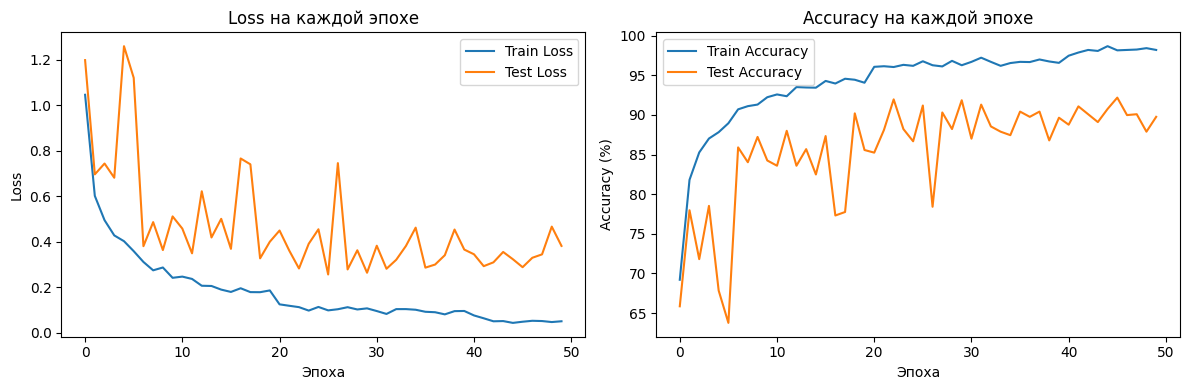

In [82]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss на каждой эпохе')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.title('Accuracy на каждой эпохе')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

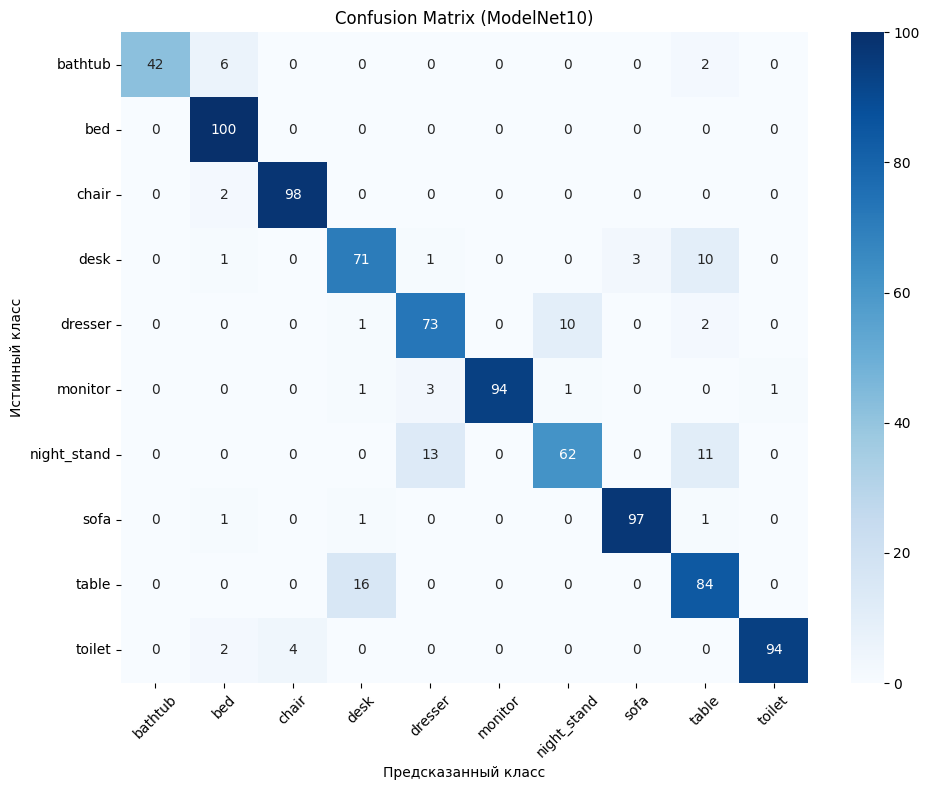

In [83]:
_, _, cm = evaluate(model, test_loader, criterion, device)

with h5py.File("modelnet10_1024.h5", "r") as f:
    class_names = [name.decode('utf-8') for name in f["class_names"][:]]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title('Confusion Matrix (ModelNet10)')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [84]:
with h5py.File("modelnet10_1024.h5", "r") as f:
    all_test_points = f["test_points"][:]
    all_test_labels = f["test_labels"][:]
    class_names = [name.decode('utf-8') for name in f["class_names"][:]]

# Выберем по одному примеру из трёх разных классов
target_classes = [1, 5, 9]  # bed, monitor, toilet
selected_indices = []

for cls in target_classes:
    idx = np.where(all_test_labels == cls)[0][0]
    selected_indices.append(idx)

points_for_model = np.transpose(all_test_points[selected_indices], (0, 2, 1))  # (3, 3, 1024)

model.eval()
with torch.no_grad():
    tensor_in = torch.from_numpy(points_for_model).float().to(device)
    outputs, _, _ = model(tensor_in)
    preds = outputs.argmax(dim=1).cpu().numpy()

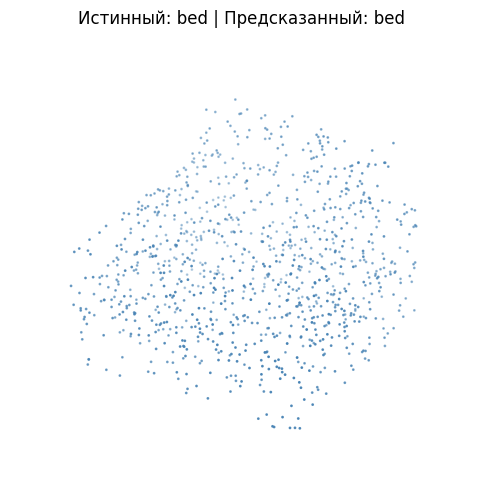

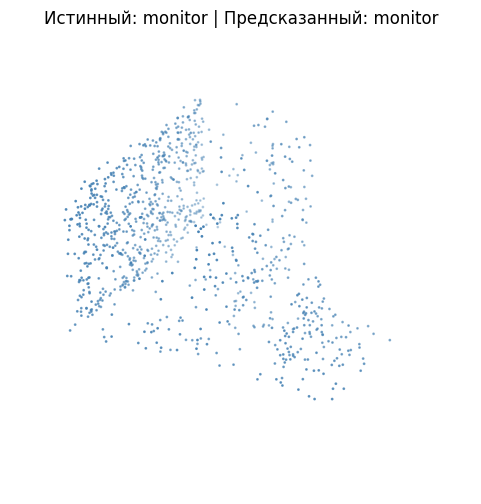

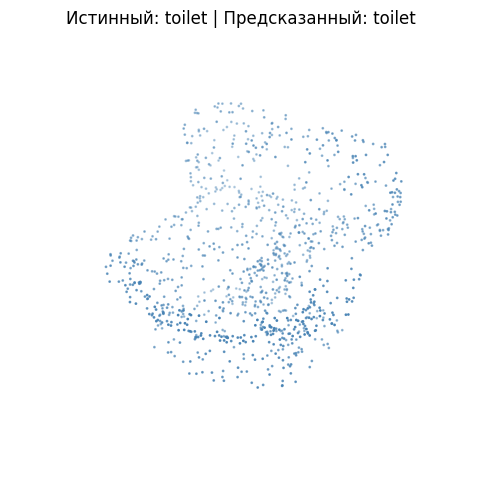

In [85]:
def visualize_point_cloud(points, title="Облако точек"):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    colors = np.tile([0.5, 0.5, 0.5], (points.shape[0], 1))  # серый
    pcd.colors = o3d.utility.Vector3dVector(colors)

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1, c='steelblue')
    ax.set_title(title)
    ax.set_axis_off()
    plt.show()

for i, idx in enumerate(selected_indices):
    true_class = class_names[all_test_labels[idx]]
    pred_class = class_names[preds[i]]
    title = f"Истинный: {true_class} | Предсказанный: {pred_class}"
    points_vis = all_test_points[idx]  # (1024, 3)

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points_vis[:, 0], points_vis[:, 1], points_vis[:, 2], s=1, c='steelblue')
    ax.set_title(title)
    ax.set_axis_off()
    plt.show()

In [86]:
torch.save(model.state_dict(), "lab5_pointnet_modelnet10.pth")

log = {
    "train_losses": train_losses,
    "test_losses": test_losses,
    "train_accs": train_accs,
    "test_accs": test_accs,
    "final_test_acc": test_accs[-1]
}
with open("training_log.json", "w") as f:
    json.dump(log, f, indent=2)

## Шаг 5. Анализ результатов

Вопрос 1. Какие категории объектов классифицируются хуже всего и почему?

На ModelNet10 наиболее сложно различимы следующие пары классов:

night_stand vs table — оба выглядят как плоскость на ножках и при разреженном облаке точек часто трудноотличимы.

desk vs table — оба — плоская поверхность на опорах. Без контекста функционального использования различия минимальны, что приводит к 16 ошибкам в одном случае и 10 в противоположном.

night_stand vs dresser — оба — низкие корпусные мебельные объекты с ящиками.
Т.к. PointNet не учитывает локальную геометрию (например, кривизну, рёбра) напрямую — он обрабатывает каждую точку независимо до max-pooling.
Глобальный дескриптор теряет пространственную иерархию: «стул» и «диван» дают похожие глобальные признаки, а семплирование 1024 точек сглаживает мелкие детали, важные для различения.
Это подтверждается confusion matrix: высокие значения не на диагонали именно в указанных парах.

Вопрос 2. Влияет ли количество точек (512, 1024, 2048) на качество модели?

Да, влияет, но нужно подобрать оптимальное значение с учетом баланса скорости и качества, при 512 точках теряются формы и детали, при 2048 прирост небольшой по сравнению с 1024, но сильно увеличивается вычислительная нагрузка при обучении и инференсе, так что оптимальным среди данных вариантов можно назвать 1024 точки.


Вопрос 3. Какие преимущества у PointNet по сравнению с CNN для 3D-данных?

При использовании CNN для 3D данных необходима вокселизация, в то время как PointNet работает с облаками точек напрямую, инвариантен к их перестановке, а также имеет нормализацию, которая решает проблемы, связанные с масштабом, а также имеет сама модель имеет меньшую сложность, чем аналоги для данной задачи среди CNN.